# 6.4 对预训练好的卷机网络微调


**Daitu：2505131775@qq.com**

In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
## 导入本章所需要的模块
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import hiddenlayer as hl

import torch
import torch.nn as nn
from torch.optim import SGD,Adam
import torch.utils.data as Data
from torchvision import models
from torchvision import transforms
from torchvision.datasets import ImageFolder

对VGG16网络进行微调，使用新的数据，训练新的分类器，并进行图像分类预测。（这要更改全连接层部分）

In [3]:
## 导入预训练好的VGG16网络
vgg16 = models.vgg16(pretrained=True)
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [4]:
## 获取vgg16的特征提取层
vgg = vgg16.features
# 将vgg16的特征提取层参数冻结，不对其进行更新
for param in vgg.parameters():
    param.requires_grad_(False)

In [5]:
## 使用VGG16的特征提取层＋新的全连接层组成新的网络
class MyVggModel(nn.Module):
    def __init__(self):
        super(MyVggModel,self).__init__()
        ## 预训练的vgg16的特征提取层
        self.vgg = vgg
        ## 添加新的全连接层
        self.classifier = nn.Sequential(
            nn.Linear(25088,512),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(512,256),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(256,10),
            nn.Softmax(dim=1)
        )
        

    ## 定义网络的向前传播路径   
    def forward(self, x):
        x = self.vgg(x)
        x = x.view(x.size(0), -1)
        output = self.classifier(x)
        return output
    
## 输出我们的网络结构
Myvggc = MyVggModel()
print(Myvggc)

MyVggModel(
  (vgg): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation

In [7]:
# ## 可视化网络结构
# hl_graph = hl.build_graph(Myvggc, torch.zeros([1, 3, 224, 224]))
# hl_graph.theme = hl.graph.THEMES["blue"].copy()  
# hl_graph

In [7]:
## 将可视化的网路保存为图片,默认格式为pdf
# hl_graph.save("data/chap5/Myvggnet_hl.png", format="png")

### 数据准备

In [8]:
## 使用10类猴子的数据集
## 对训练集的预处理
train_data_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),# 随机长宽比裁剪为224*224
    transforms.RandomHorizontalFlip(),# 依概率p=0.5水平翻转
    transforms.ToTensor(), # 转化为张量并归一化至[0-1]
    ## 图像标准化处理
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
    
## 对验证集的预处理  
val_data_transforms = transforms.Compose([
    transforms.Resize(256), # 重置图像分辨率
    transforms.CenterCrop(224),#依据给定的size从中心裁剪 
    transforms.ToTensor(),# 转化为张量并归一化至[0-1]
    ## 图像标准化处理
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [9]:
## 读取图像
train_data_dir = "data/chap6/10-monkey-species/training"
train_data = ImageFolder(train_data_dir, transform=train_data_transforms)
train_data_loader = Data.DataLoader(train_data,batch_size=32,
                                    shuffle=True,num_workers=2)
## 读取验证集
val_data_dir = "data/chap6/10-monkey-species/validation"
val_data = ImageFolder(val_data_dir, transform=val_data_transforms)
val_data_loader = Data.DataLoader(val_data,batch_size=32,
                                  shuffle=True,num_workers=2)


print("训练集样本数:",len(train_data.targets))
print("验证集样本数:",len(val_data.targets))


##  获得一个batch的数据
for step, (b_x, b_y) in enumerate(train_data_loader):  
    if step > 0:
        break

## 输出训练图像的尺寸和标签的尺寸
print(b_x.shape)
print(b_y.shape)


训练集样本数: 1097
验证集样本数: 272
torch.Size([32, 3, 224, 224])
torch.Size([32])


In [10]:
len(val_data.targets)
len(train_data.targets)

1097

In [11]:
print(len(val_data_loader))
print(len(train_data_loader))

9
35


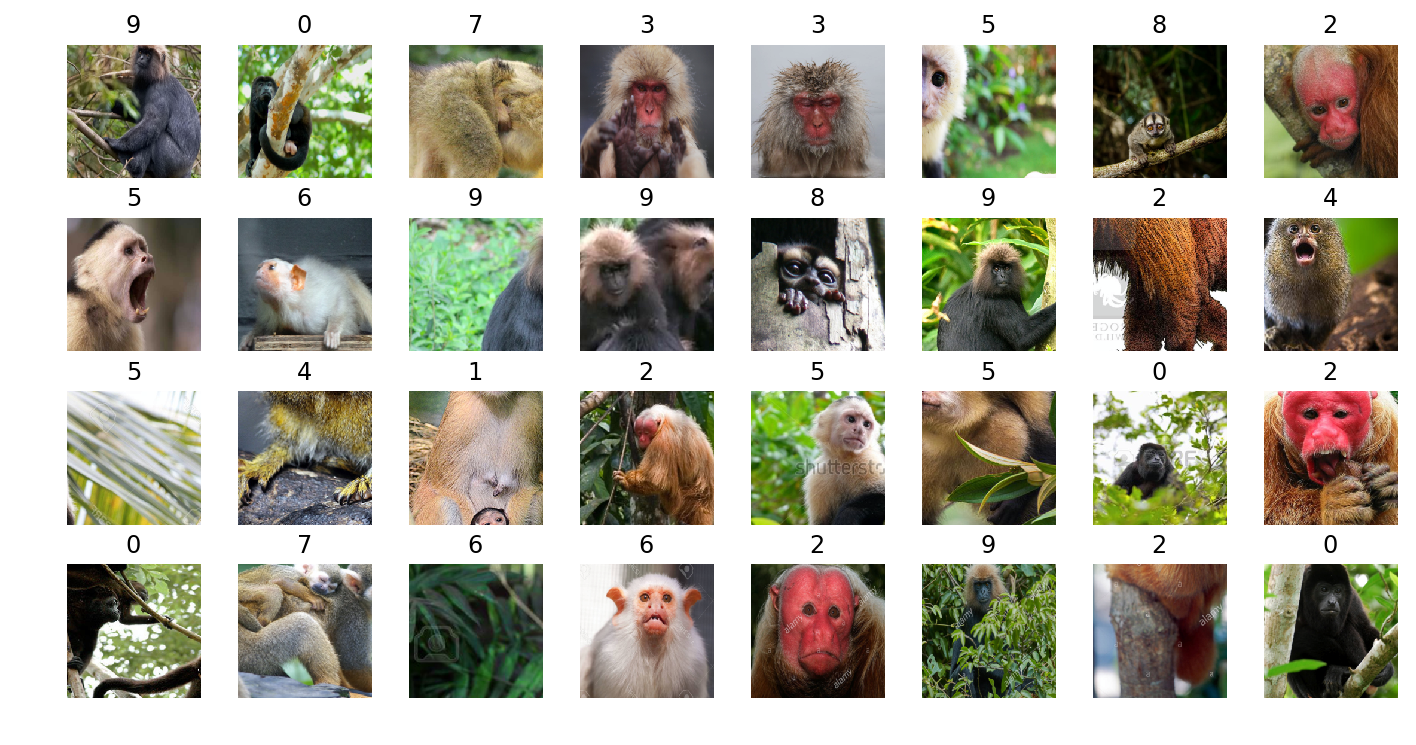

In [12]:
## 可视化训练集其中一个batch的图像
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.figure(figsize=(12,6))
for ii in np.arange(len(b_y)):
    plt.subplot(4,8,ii+1)
    image = b_x[ii,:,:,:].numpy().transpose((1, 2, 0))
    image = std * image + mean
    image = np.clip(image, 0, 1)
    plt.imshow(image)
    plt.title(b_y[ii].data.numpy())
    plt.axis("off")
plt.subplots_adjust(hspace = 0.3)

torch.Size([32, 3, 224, 224])
torch.Size([32])


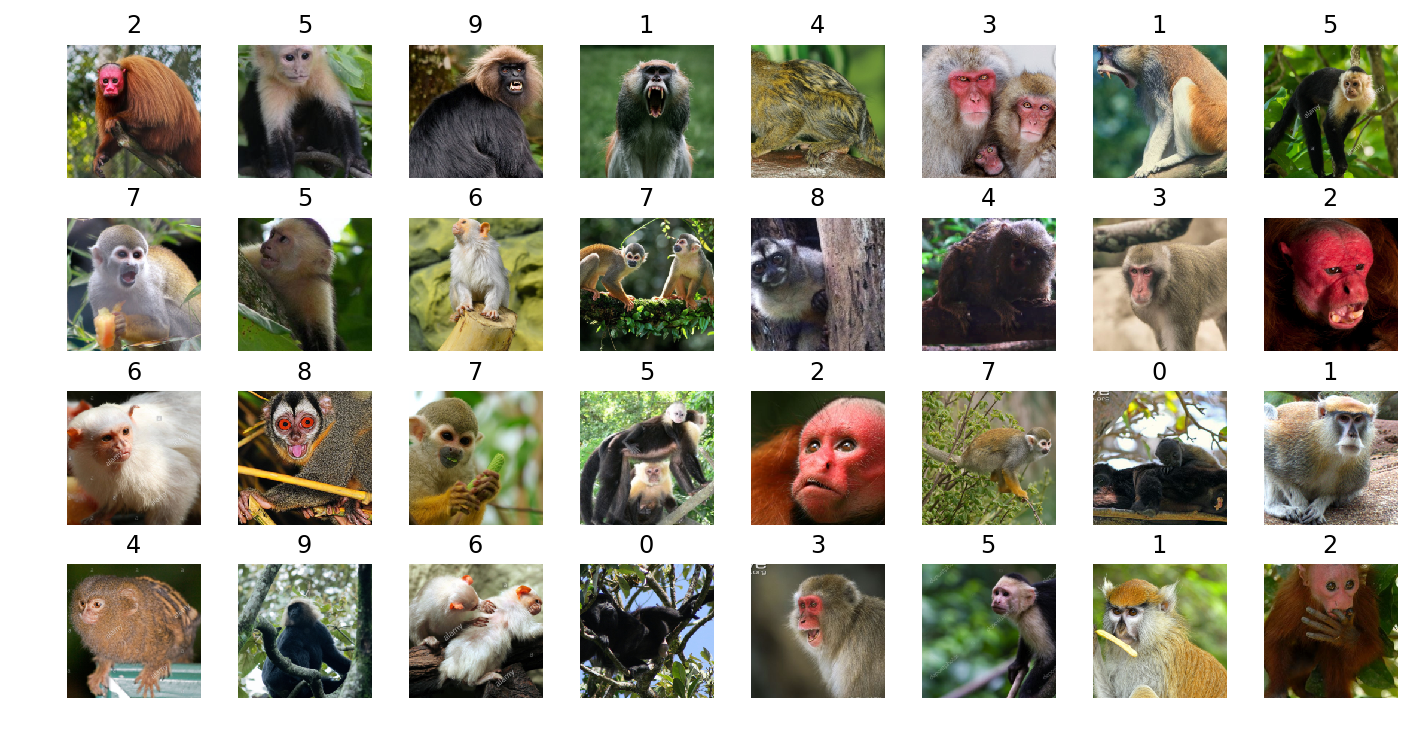

In [13]:
##  获得一个batch的数据
for step, (b_x, b_y) in enumerate(val_data_loader):  
    if step > 0:
        break

## 输出训练图像的尺寸和标签的尺寸
print(b_x.shape)
print(b_y.shape)

## 可视化验证集其中一个batch的图像
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.figure(figsize=(12,6))
for ii in np.arange(len(b_y)):
    plt.subplot(4,8,ii+1)
    image = b_x[ii,:,:,:].numpy().transpose((1, 2, 0))
    image = std * image + mean
    image = np.clip(image, 0, 1)
    plt.imshow(image)
    plt.title(b_y[ii].data.numpy())
    plt.axis("off")
plt.subplots_adjust(hspace = 0.3)

### 模型的训练过程

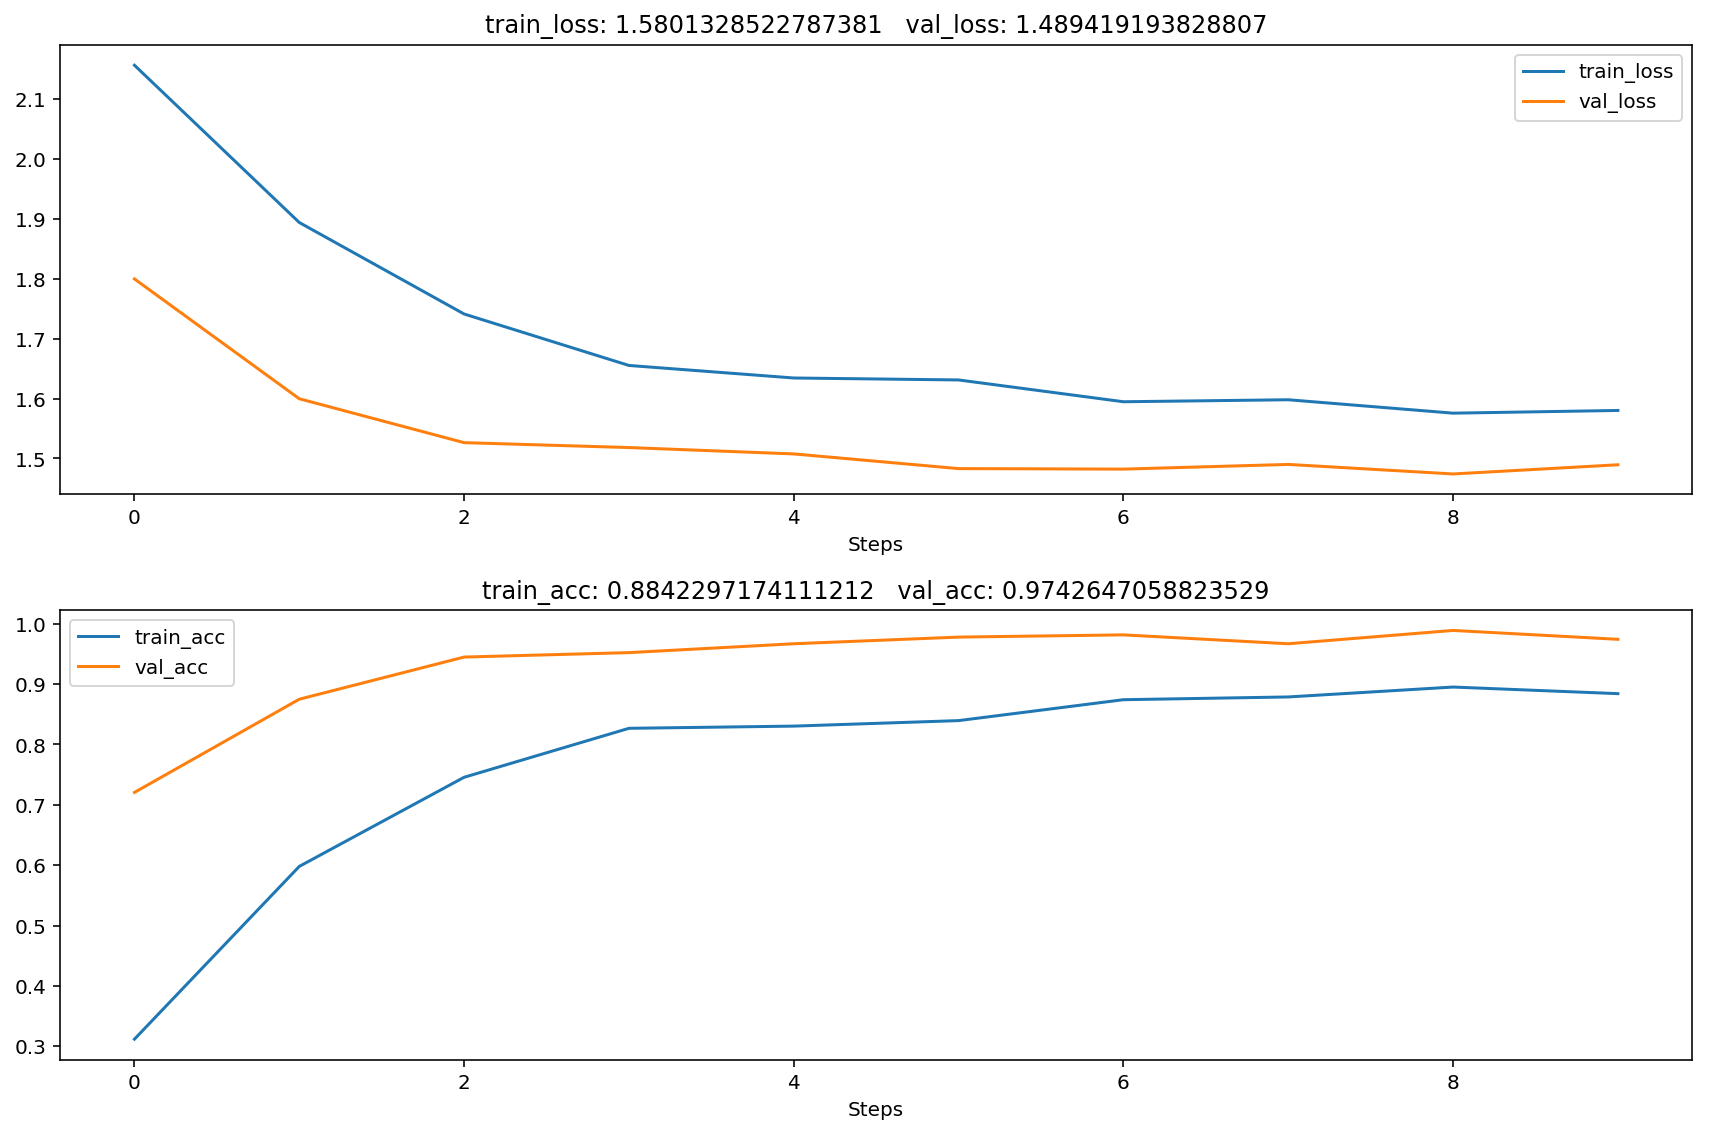

In [14]:
# 定义优化器
optimizer = torch.optim.Adam(Myvggc.parameters(), lr=0.0003)  
loss_func = nn.CrossEntropyLoss()   # 损失函数
# 记录训练过程的指标
history1 = hl.History()
# 使用Canvas进行可视化
canvas1 = hl.Canvas()
## 对模型进行迭代训练,对所有的数据训练EPOCH轮
for epoch in range(10):
    train_loss_epoch = 0
    val_loss_epoch = 0
    train_corrects =0
    val_corrects = 0
    ## 对训练数据的迭代器进行迭代计算
    Myvggc.train()
    for step, (b_x, b_y) in enumerate(train_data_loader):  
        ## 计算每个batch的
        output = Myvggc(b_x)            # CNN在训练batch上的输出
        loss = loss_func(output, b_y)   # 交叉熵损失函数
        pre_lab = torch.argmax(output,1)
        optimizer.zero_grad()           # 每个迭代步的梯度初始化为0
        loss.backward()                 # 损失的后向传播，计算梯度
        optimizer.step()                # 使用梯度进行优化
        train_loss_epoch += loss.item() * b_x.size(0)
        train_corrects += torch.sum(pre_lab == b_y.data)
    ## 计算一个epoch的损失和精度
    train_loss = train_loss_epoch / len(train_data.targets)
    train_acc = train_corrects.double() / len(train_data.targets)
    
    ## 计算在验证集上的表现
    Myvggc.eval()
    for step, (val_x, val_y) in enumerate(val_data_loader):  
        output = Myvggc(val_x)
        loss = loss_func(output, val_y)
        pre_lab = torch.argmax(output,1)
        val_loss_epoch += loss.item() * val_x.size(0)
        val_corrects += torch.sum(pre_lab == val_y.data)
    ## 计算一个epoch的损失和精度
    val_loss = val_loss_epoch / len(val_data.targets)
    val_acc = val_corrects.double() / len(val_data.targets)

    ## 保存每个epoch上的输出loss和acc
    history1.log(epoch,train_loss=train_loss,
                 val_loss = val_loss,
                 train_acc = train_acc.item(),
                 val_acc = val_acc.item()
                )
    # 可视网络训练的过程
    with canvas1:
        canvas1.draw_plot([history1["train_loss"],history1["val_loss"]])
        canvas1.draw_plot([history1["train_acc"],history1["val_acc"]])


In [17]:
## 保存模型
torch.save(Myvggc,"data/chap6/Myvggc.pkl")

/Users/daitu/anaconda3/envs/python35/lib/python3.5/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type MyVggModel. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [18]:
## 导入保存的模型
Myvggc2 = torch.load("data/chap6/Myvggc.pkl")
Myvggc2

MyVggModel(
  (vgg): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv